<a href="https://colab.research.google.com/github/shavinkalu23/7318_assignment_2/blob/main/7318_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision.transforms.v2 import ToTensor,Resize,Compose,ColorJitter,RandomRotation,RandomAffine, AugMix,RandomCrop,GaussianBlur,RandomEqualize,RandomHorizontalFlip,RandomVerticalFlip, Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split

SEED = 42

torch.manual_seed(SEED)

# If you are using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# transform = Compose([
#     Resize([32,32]),
#     ToTensor(),
# ])
# Load the entire GTSRB dataset
full_dataset = torchvision.datasets.GTSRB(root='./data',
                                          split='train',
                                          download=True)

# 80-20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset_org = random_split(full_dataset, [train_size, test_size])

# Further split training data into training and validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset_org, val_dataset_org = random_split(train_dataset, [train_size, val_size])

# def compute_mean_std(loader):
#     mean = 0.
#     std = 0.
#     nb_samples = 0.

#     for data, _ in loader:
#         batch_samples = data.size(0)
#         data = data.view(batch_samples, data.size(1), -1)
#         mean += data.mean(2).sum(0)
#         std += data.std(2).sum(0)
#         nb_samples += batch_samples

#     mean /= nb_samples
#     std /= nb_samples

#     return mean, std

# train_loader_for_stats = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)
# mean, std = compute_mean_std(train_loader_for_stats)
# print(mean,std)

mean = (0.3337, 0.3064, 0.3171)
std =  ( 0.2672, 0.2564, 0.2629)

train_transforms = Compose([
    Resize([32,32]),
    ToTensor(),
    Normalize((mean), (std))
])




validation_transforms = Compose([
    Resize([32,32]),
    ToTensor(),
    Normalize((mean), (std))
])

test_transforms = Compose([
    Resize([32,32]),
    ToTensor(),
    Normalize((mean), (std))
])

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Apply transformations
train_dataset = CustomDataset(train_dataset_org, transform=train_transforms)
val_dataset = CustomDataset(val_dataset_org, transform=validation_transforms)
test_dataset = CustomDataset(test_dataset_org, transform=test_transforms)

BS = 64

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





100%|██████████| 187490228/187490228 [00:07<00:00, 26342905.18it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
def training_metrics(positives, data_size, loss):
    acc = positives / data_size
    return loss, acc

def validation_metrics(validation_data, loss_function, model):
    data_size = len(validation_data.dataset)
    correct_predictions = 0
    total_samples = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for step, (input, label) in enumerate(validation_data):
            input, label = input.to(device), label.to(device)
            prediction = model(input)
            loss = loss_function(prediction, label)
            val_loss += loss.item()
            _, predicted = torch.max(prediction, 1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

    val_acc = correct_predictions / total_samples
    return val_loss / len(validation_data), val_acc


In [ ]:
def compile(train_data, validation_data, epochs, loss_function, optimizer, model, learning_rate_scheduler= None, early_stopping = None):
    val_acc_list = []
    val_loss_list = []

    train_acc_list = []
    train_loss_list = []

    learning_rate_list = []

    print('Training started ...')
    STEPS = len(train_data)
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]["lr"]
        learning_rate_list.append(lr)
        correct_predictions = 0
        total_examples = 0
        loss_val = 0

        pbar = tqdm(enumerate(train_data), total=STEPS, desc=f"Epoch [{epoch+1}/{epochs}]")
        for step, (input, label) in pbar:
            input, label = input.to(device), label.to(device)
            prediction = model(input)

            _, predicted = torch.max(prediction, 1)
            correct_predictions += (predicted == label).sum().item()
            total_examples += label.size(0)

            loss = loss_function(prediction, label)
            loss_val += loss.item()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            pbar.set_postfix({
                "Learning Rate": lr,
                "Loss": f"{loss.item():.4f}",
                "Accuracy": f"{correct_predictions/total_examples:.4f}"
            })

        training_loss, training_acc = training_metrics(correct_predictions, total_examples, loss_val / len(train_data))
        train_acc_list.append(training_acc)
        train_loss_list.append(training_loss)

        val_loss, val_acc = validation_metrics(validation_data, loss_function, model)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}')

        if early_stopping:
          early_stopping.step(val_loss)
          if early_stopping.stop:
              break
        if learning_rate_scheduler:
          learning_rate_scheduler.step()

    metrics_dict = {
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'val_acc': val_acc_list,
        'val_loss': val_loss_list,
        'learning_rate': learning_rate_list
    }

    return metrics_dict

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

EPOCHS = 5
LEARNING_RATE = 0.001


model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss = nn.CrossEntropyLoss()
base_cnn_metrics = compile(model =model, train_data=train_loader,validation_data=val_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer)

Training started ...


Epoch [1/5]: 100%|██████████| 267/267 [00:16<00:00, 16.34it/s, Learning Rate=0.001, Loss=3.6109, Accuracy=0.0503]


Validation Accuracy: 0.0713, Validation Loss: 3.5707


Epoch [2/5]: 100%|██████████| 267/267 [00:07<00:00, 34.99it/s, Learning Rate=0.001, Loss=3.4021, Accuracy=0.0980]


Validation Accuracy: 0.1239, Validation Loss: 3.3560


Epoch [3/5]: 100%|██████████| 267/267 [00:09<00:00, 27.65it/s, Learning Rate=0.001, Loss=3.5403, Accuracy=0.1294]


Validation Accuracy: 0.1558, Validation Loss: 3.1991


Epoch [4/5]: 100%|██████████| 267/267 [00:11<00:00, 22.71it/s, Learning Rate=0.001, Loss=2.4748, Accuracy=0.2157]


Validation Accuracy: 0.2740, Validation Loss: 2.7057


Epoch [5/5]: 100%|██████████| 267/267 [00:11<00:00, 23.22it/s, Learning Rate=0.001, Loss=2.0912, Accuracy=0.3470]


Validation Accuracy: 0.4680, Validation Loss: 1.9527


In [ ]:
torch.save(model, '/content/drive/My Drive/base_model.pth')

Data augmentation can introduce variance into the dataset and reduce overfitting. Given the GTSRB dataset contains traffic signs which can be captured under various conditions, we can use a few common augmentations:

In [ ]:
mean = (0.3337, 0.3064, 0.3171)
std =  ( 0.2672, 0.2564, 0.2629)

train_aug_transforms = Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    Resize([32,32]),
    ToTensor(),
    Normalize((mean), (std))
])
train_aug_dataset = CustomDataset(train_dataset , transform=train_aug_transforms)

BS = 64

# Data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset,train_aug_dataset]), batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss = nn.CrossEntropyLoss()
base_cnn_aug_metrics = compile(model =model, train_data=train_loader,validation_data=val_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer)

Training started ...


Epoch [1/5]: 100%|██████████| 533/533 [00:59<00:00,  8.98it/s, Learning Rate=0.001, Loss=3.2465, Accuracy=0.0596]


Validation Accuracy: 0.1006, Validation Loss: 3.4184


Epoch [2/5]: 100%|██████████| 533/533 [00:50<00:00, 10.55it/s, Learning Rate=0.001, Loss=3.1005, Accuracy=0.1475]


Validation Accuracy: 0.2519, Validation Loss: 2.8873


Epoch [3/5]: 100%|██████████| 533/533 [00:51<00:00, 10.40it/s, Learning Rate=0.001, Loss=2.4322, Accuracy=0.2748]


Validation Accuracy: 0.4419, Validation Loss: 2.1388


Epoch [4/5]: 100%|██████████| 533/533 [00:52<00:00, 10.25it/s, Learning Rate=0.001, Loss=2.2555, Accuracy=0.3919]


Validation Accuracy: 0.5510, Validation Loss: 1.6191


Epoch [5/5]: 100%|██████████| 533/533 [00:52<00:00, 10.06it/s, Learning Rate=0.001, Loss=1.8907, Accuracy=0.4855]


Validation Accuracy: 0.6798, Validation Loss: 1.2066


In [ ]:
torch.save(model, '/content/drive/My Drive/base_model_aug.pth')

In [ ]:
#convert the images to size 224x224 to support input size of VGG16 and Resnet34
train_transforms = Compose([
    Resize([224,224]),
    ToTensor(),
    Normalize((mean), (std))
])

validation_transforms = Compose([
    Resize([224,224]),
    ToTensor(),
    Normalize((mean), (std))
])

test_transforms = Compose([
    Resize([224,224]),
    ToTensor(),
    Normalize((mean), (std))
])

train_aug_transforms = Compose([
    RandomHorizontalFlip(),
    RandomRotation(10),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    Resize([224,224]),
    ToTensor(),
    Normalize((mean), (std))
])

In [ ]:
# Apply transformations
train_dataset = CustomDataset(train_dataset_org, transform=train_transforms)
val_dataset = CustomDataset(val_dataset_org, transform=validation_transforms)
test_dataset = CustomDataset(test_dataset_org, transform=test_transforms)

BS = 64

train_aug_dataset = CustomDataset(train_dataset , transform=train_aug_transforms)

# Data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset,train_aug_dataset]), batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
EPOCHS = 5
LEARNING_RATE = 0.001
INPUT_DIM = 3*32*32
OUTPUT_DIM = 43
# Load the VGG16 model
vgg16 = models.vgg16(pretrained=False)  # We use a non-pretrained model for this task
vgg16.classifier[6] = nn.Linear(4096, 43)  # Change the last layer to have 43 outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = vgg16.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

vgg16_1_metrics = compile(model =model, train_data=train_loader,validation_data=val_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training started ...


Epoch [1/5]: 100%|██████████| 533/533 [11:30<00:00,  1.30s/it, Learning Rate=0.001, Loss=2.5757, Accuracy=0.1504]


Validation Accuracy: 0.4063, Validation Loss: 1.9491


Epoch [2/5]: 100%|██████████| 533/533 [11:39<00:00,  1.31s/it, Learning Rate=0.001, Loss=1.6182, Accuracy=0.4177]


Validation Accuracy: 0.7673, Validation Loss: 0.7236


Epoch [3/5]: 100%|██████████| 533/533 [11:38<00:00,  1.31s/it, Learning Rate=0.001, Loss=1.2378, Accuracy=0.6206]


Validation Accuracy: 0.8968, Validation Loss: 0.3289


Epoch [4/5]: 100%|██████████| 533/533 [11:53<00:00,  1.34s/it, Learning Rate=0.001, Loss=0.6690, Accuracy=0.7161]


Validation Accuracy: 0.9510, Validation Loss: 0.1490


Epoch [5/5]: 100%|██████████| 533/533 [11:54<00:00,  1.34s/it, Learning Rate=0.001, Loss=0.7558, Accuracy=0.7606]


Validation Accuracy: 0.9704, Validation Loss: 0.0973


In [ ]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/Models/vgg16.pth')

In [ ]:
 # Load the resnet34 model
resnet34 = models.resnet34(pretrained=False)  # We use a non-pretrained model for this task
resnet34.fc = nn.Linear(resnet34.fc.in_features, 43)  # Change the final fully connected layer to have 43 outputs

model = resnet34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

resnet_metrics = compile(model =model, train_data=train_loader,validation_data=val_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer)
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/Models/resnet34.pth')




Training started ...


Epoch [1/5]: 100%|██████████| 533/533 [04:22<00:00,  2.03it/s, Learning Rate=0.001, Loss=2.9008, Accuracy=0.1354]


Validation Accuracy: 0.2548, Validation Loss: 3.0069


Epoch [2/5]: 100%|██████████| 533/533 [04:14<00:00,  2.10it/s, Learning Rate=0.001, Loss=2.2076, Accuracy=0.2460]


Validation Accuracy: 0.4764, Validation Loss: 1.6113


Epoch [3/5]: 100%|██████████| 533/533 [04:14<00:00,  2.10it/s, Learning Rate=0.001, Loss=1.5765, Accuracy=0.4045]


Validation Accuracy: 0.7011, Validation Loss: 0.9228


Epoch [4/5]: 100%|██████████| 533/533 [04:17<00:00,  2.07it/s, Learning Rate=0.001, Loss=1.4903, Accuracy=0.5629]


Validation Accuracy: 0.8689, Validation Loss: 0.4273


Epoch [5/5]: 100%|██████████| 533/533 [04:13<00:00,  2.10it/s, Learning Rate=0.001, Loss=1.0591, Accuracy=0.6275]


Validation Accuracy: 0.8820, Validation Loss: 0.3333


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_score = score
            self.counter = 0




In [ ]:
# Sample randomly from the hyperparameter space
hyperparameters_space = {
    'batch_size': [16, 32, 64, 128],
    'lr': [1e-3, 1e-4, 5e-5, 5e-4],
    'momentum': [0.9, 0.95, 0.99],
    'optimizer': ['Adam','SGD'],
    'weight_decay': [0, 1e-5, 1e-4],   # Regularization for Adam
}

num_samples = 5
random_search = []
import random
for _ in range(num_samples):
    sample = {}
    for k, v in hyperparameters_space.items():
        sample[k] = random.choice(v)
    random_search.append(sample)

random_search = random.sample(random_search, num_samples)
print(random_search)


best_accuracy = 0.0
best_params = None
MAX_EPOCHS = 5  # Setting an upper bound on epochs, you can adjust this
results = []
for params in random_search:
    # Define data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)

    # Define model, loss, optimizer with current hyperparameters
    model = models.vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 43)
    model.to(device)
    # Define optimizer based on the current hyperparameters
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    ...
    criterion = nn.CrossEntropyLoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)

    # Use the compile function for training
    metrics = compile(train_loader, val_loader, MAX_EPOCHS, criterion, optimizer, model)


    # Assuming the last value in the val_acc_list is for the latest epoch
    accuracy = metrics['val_acc'][-1]
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params


    results.append({
        'batch_size': params['batch_size'],
        'lr': params['lr'],
        'momentum': params['momentum'],
        'optimizer': params['optimizer'],
        'weight_decay': params['weight_decay'],
        'val_acc': val_acc
    })

df = pd.DataFrame(results, index=False)
df.to_csv('hyper_results')
print(f"Best validation accuracy: {best_accuracy}")
print(f"Best hyperparameters: {best_params}")

In [ ]:

# Best Model
BS = 16
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.95
# Apply transformations
train_dataset = CustomDataset(train_dataset_org, transform=train_transforms)
val_dataset = CustomDataset(val_dataset_org, transform=validation_transforms)
test_dataset = CustomDataset(test_dataset_org, transform=test_transforms)

train_aug_dataset = CustomDataset(train_dataset , transform=train_aug_transforms)

# Data loaders
train_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset,train_aug_dataset]), batch_size=BS, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=2, pin_memory=True)

# Load the VGG16 model
vgg16 = models.vgg16(pretrained=False)  # We use a non-pretrained model for this task
vgg16.classifier[6] = nn.Linear(4096, 43)  # Change the last layer to have 43 outputs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16.to(device)
optimizer = optim.SGD(params=model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)
lr_s = optim.lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()




In [6]:
vgg_final_metrics = compile(model =model, train_data=train_loader,validation_data=val_loader,epochs=EPOCHS,loss_function=loss,optimizer=optimizer,learning_rate_scheduler=lr_s)

Training started ...


Epoch [1/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.5186, Validation Loss: 1.4262


Epoch [2/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9418, Validation Loss: 0.1679


Epoch [3/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9740, Validation Loss: 0.0749


Epoch [4/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9770, Validation Loss: 0.0833


Epoch [5/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9916, Validation Loss: 0.0334


Epoch [6/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9927, Validation Loss: 0.0337


Epoch [7/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9948, Validation Loss: 0.0239


Epoch [8/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9948, Validation Loss: 0.0198


Epoch [9/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Validation Accuracy: 0.9918, Validation Loss: 0.0299


Epoch [10/10]:   0%|          | 0/2132 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from Non

Validation Accuracy: 0.9951, Validation Loss: 0.0219


In [9]:

def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['train_acc']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_dict['train_acc'], label='Training Accuracy', marker='o')
    plt.plot(epochs, metrics_dict['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_dict['train_loss'], label='Training Loss', marker='o')
    plt.plot(epochs, metrics_dict['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

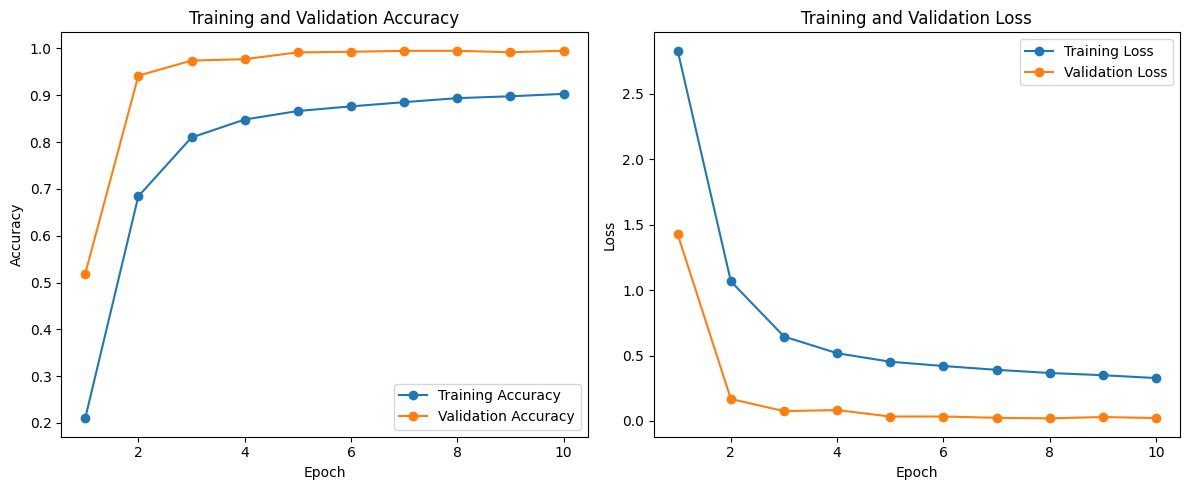

In [11]:
plot_metrics(vgg_final_metrics)

In [7]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/Models/vgg_16_final.pth')

RuntimeError: ignored

In [12]:
def evaluate(data_loader, model, loss_function):
    data_size = len(data_loader.dataset)
    correct_predictions = 0
    total_samples = 0
    total_loss = 0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for step, (input, label) in enumerate(data_loader):
            input, label = input.to(device), label.to(device)
            prediction = model(input)
            loss = loss_function(prediction, label)
            total_loss += loss.item()
            _, predicted = torch.max(prediction, 1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(data_loader)
    return average_loss, accuracy

# Now, to compute the accuracy on the test dataset:

test_loss, test_accuracy = evaluate(test_loader, model, loss_function = loss)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9968, Test Loss: 0.0109
